# 19대 대선 자료 분석하기


## 6-1. Selenium과 Beautiful Soup을 이용한 데이터 획득 준비 작업

In [1]:
import pandas as pd
import numpy as np

import platform
import matplotlib.pyplot as plt

%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')    

plt.rcParams['axes.unicode_minus'] = False

In [2]:
from selenium import webdriver
import time

In [3]:
driver = webdriver.Chrome('../driver/chromedriver')
driver.get("http://info.nec.go.kr/main/showDocument.xhtml?electionId=0000000000&topMenuId=VC&secondMenuId=VCCP09")

* **대통령선거**라는 글자부분을 클릭합니다. 해당 글자에서 앞 장에서 설명한 크롬 개발자 도구로 코드를 확인하면 **id**가 **electionType1**으로 나타납니다.

In [4]:
driver.find_element_by_id("electionType1").click()

* 그리고 나타나는 선택항목에서 **제19대**를 선택하도록 합니다. 역시 크롬 개발자 도구에서 해당 위치의 id는 **electionName**이라는 것을 찾을 수 있습니다.

In [5]:
driver.find_element_by_id("electionName").send_keys("제19대")

* 그리고 나타나는 선택에서 **대통령선거**를 선택하도록 합니다.

In [6]:
driver.find_element_by_id("electionCode").send_keys("대통령선거")

* 이제 나타나는 시도 항목에서 선택 부분의 XPath를 찾고, 해당 리스트를 가져옵니다

In [7]:
sido_list_raw = driver.find_element_by_xpath("""//*[@id="cityCode"]""")
sido_list = sido_list_raw.find_elements_by_tag_name("option")
sido_names_values = [option.text for option in sido_list]
sido_names_values = sido_names_values[2:]
sido_names_values

['서울특별시',
 '부산광역시',
 '대구광역시',
 '인천광역시',
 '광주광역시',
 '대전광역시',
 '울산광역시',
 '세종특별자치시',
 '경기도',
 '강원도',
 '충청북도',
 '충청남도',
 '전라북도',
 '전라남도',
 '경상북도',
 '경상남도',
 '제주특별자치도']

## 6-2. 19대 대선 개표 결과 데이터 획득하기

<img src="../img/002.jpg" width="600" height="400"></img>

* 위 그림이 지역을 선택하면 나타나는 화면중 하나인데 득표수에 득표율이 괄호()로 함께 나타납니다.
* 이를 제거하고 **(**를 기준으로 왼쪽 숫자만 얻어서, 콤마(,)를 제거하고, float형으로 변경하는 함수를 **get_num**으로 준비해 둡니다

In [8]:
import re

def get_num(tmp):
    return float(re.split('\(', tmp)[0].replace(',',''))

# 아래 모듈을 import해서 wait.until 함수를 사용할 수 있습니다.

<img src="../img/003.jpg" width="600" height="200"></img>

* 이 함수는 **검색**버튼이 클릭가능할 때 까지 기다리는 기능을 합니다.
* 그리고 **move_sido** 함수는 광역시도 이름을 리스트에 전송하고 검색 버튼을 누르는 역할을 합니다.

In [9]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

wait = WebDriverWait(driver, 10)

def move_sido(name):
    element = driver.find_element_by_id("cityCode")
    element.send_keys(name)
    make_xpath = """//*[@id="searchBtn"]"""
    wait.until(EC.element_to_be_clickable((By.XPATH,make_xpath)))
    driver.find_element_by_xpath(make_xpath).click() 

* **append_data** 함수는 빈 내용으로 미리 준비한 DataFrame에 append 명령으로 읽은 데이터를 하나씩 추가하는 기능입니다.

<img src="../img/002.jpg" width="600" height="400"></img>

* 이 함수가 실행되면 전체 투표수, 문재인후보, 홍준표후보, 안철수후보의 득표수가 추가됩니다

In [10]:
def append_data(df, sido_name, data):
    for each in df[0].values[1:]:
        data['광역시도'].append(sido_name)
        data['시군'].append(each[0])
        data['pop'].append(get_num(each[2]))
        data['moon'].append(get_num(each[3]))
        data['hong'].append(get_num(each[4]))
        data['ahn'].append(get_num(each[5]))

* 미리 변수를 하나 만들어 둡니다.

In [11]:
election_result_raw = {'광역시도' : [],
                       '시군' : [],
                       'pop' : [],
                       'moon' : [],
                       'hong' : [],    
                       'ahn' : [] }

* 교재를 집필할 때는 table로 읽는 것이 부담된다고 판단했는데, 지금은 형태가 바뀌어서 html 태그 중 table로 되어 있는 부분을 Beautiful Soup으로 읽어서 padnas의 read_html로 읽는 것이 더 유리합니다.

In [13]:
from bs4 import BeautifulSoup

for each_sido in sido_names_values:
    move_sido(each_sido)
    
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find('table')
    
    df = pd.read_html(str(table))
    
    append_data(df, each_sido, election_result_raw)

In [14]:
election_result = pd.DataFrame(election_result_raw, 
                               columns=['광역시도', '시군', 'pop', 'moon','hong','ahn'])
election_result

,광역시도,시군,pop,moon,hong,ahn
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0
5,서울특별시,동대문구,236092.0,98958.0,51631.0,53359.0
6,서울특별시,중랑구,265706.0,111450.0,56545.0,62778.0
7,서울특별시,성북구,295866.0,129263.0,57584.0,66518.0
8,서울특별시,강북구,210614.0,89645.0,42268.0,51669.0
9,서울특별시,도봉구,229233.0,94898.0,47461.0,55600.0


In [15]:
election_result.to_csv('../data/05. election_result.csv', encoding='utf-8', sep=',')

In [16]:
driver.close()

## 6-3. 각 후보의 득표율과 지역 ID 정리하기

In [2]:
election_result = pd.read_csv('../data/05. election_result.csv', encoding='utf-8', 
                              index_col=0)
election_result.head()

,광역시도,시군,pop,moon,hong,ahn
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0


In [3]:
sido_candi =  election_result['광역시도']
sido_candi = [name[:2] if name[:2] 
                                          in ['서울','부산','대구','광주','인천','대전','울산']
                                    else '' for name in sido_candi]

In [4]:
def cut_char_sigu(name):
    return name if len(name)==2 else name[:-1]

In [5]:
import re

sigun_candi = ['']*len(election_result)

for n in election_result.index:
    each = election_result['시군'][n]
    if each[:2] in ['수원', '성남','안양','안산','고양',
                            '용인','청주','천안','전주','포항','창원']:
        sigun_candi[n] = re.split('시', each)[0]+' '+ \
                                                        cut_char_sigu(re.split('시', each)[1])
    else:
        sigun_candi[n] = cut_char_sigu(each)
        
sigun_candi

['종로',
 '중구',
 '용산',
 '성동',
 '광진',
 '동대문',
 '중랑',
 '성북',
 '강북',
 '도봉',
 '노원',
 '은평',
 '서대문',
 '마포',
 '양천',
 '강서',
 '구로',
 '금천',
 '영등포',
 '동작',
 '관악',
 '서초',
 '강남',
 '송파',
 '강동',
 '중구',
 '서구',
 '동구',
 '영도',
 '부산진',
 '동래',
 '남구',
 '북구',
 '해운대',
 '기장',
 '사하',
 '금정',
 '강서',
 '연제',
 '수영',
 '사상',
 '중구',
 '동구',
 '서구',
 '남구',
 '북구',
 '수성',
 '달서',
 '달성',
 '중구',
 '동구',
 '남구',
 '연수',
 '남동',
 '부평',
 '계양',
 '서구',
 '강화',
 '옹진',
 '동구',
 '서구',
 '남구',
 '북구',
 '광산',
 '동구',
 '중구',
 '서구',
 '유성',
 '대덕',
 '중구',
 '남구',
 '동구',
 '북구',
 '울주',
 '세종특별자치',
 '수원 장안',
 '수원 권선',
 '수원 팔달',
 '수원 영통',
 '성남 수정',
 '성남 중원',
 '성남 분당',
 '의정부',
 '안양 만안',
 '안양 동안',
 '부천',
 '광명',
 '평택',
 '양주',
 '동두천',
 '안산 상록',
 '안산 단원',
 '고양 덕양',
 '고양 일산동',
 '고양 일산서',
 '과천',
 '의왕',
 '구리',
 '남양주',
 '오산',
 '화성',
 '시흥',
 '군포',
 '하남',
 '파주',
 '여주',
 '이천',
 '용인 처인',
 '용인 수지',
 '용인 기흥',
 '안성',
 '김포',
 '광주',
 '포천',
 '연천',
 '양평',
 '가평',
 '춘천',
 '원주',
 '강릉',
 '동해',
 '삼척',
 '태백',
 '정선',
 '속초',
 '고성',
 '양양',
 '인제',
 '홍천',
 '횡성',
 '영월',
 '평창',
 '화천',
 '양구

In [6]:
ID_candi = [sido_candi[n]+' '+sigun_candi[n] for n in range(0,len(sigun_candi))]

ID_candi = [name[1:] if name[0]==' ' else name for name in ID_candi]
ID_candi = [name[:2] if name[:2]=='세종' else name for name in ID_candi]

ID_candi

['서울 종로',
 '서울 중구',
 '서울 용산',
 '서울 성동',
 '서울 광진',
 '서울 동대문',
 '서울 중랑',
 '서울 성북',
 '서울 강북',
 '서울 도봉',
 '서울 노원',
 '서울 은평',
 '서울 서대문',
 '서울 마포',
 '서울 양천',
 '서울 강서',
 '서울 구로',
 '서울 금천',
 '서울 영등포',
 '서울 동작',
 '서울 관악',
 '서울 서초',
 '서울 강남',
 '서울 송파',
 '서울 강동',
 '부산 중구',
 '부산 서구',
 '부산 동구',
 '부산 영도',
 '부산 부산진',
 '부산 동래',
 '부산 남구',
 '부산 북구',
 '부산 해운대',
 '부산 기장',
 '부산 사하',
 '부산 금정',
 '부산 강서',
 '부산 연제',
 '부산 수영',
 '부산 사상',
 '대구 중구',
 '대구 동구',
 '대구 서구',
 '대구 남구',
 '대구 북구',
 '대구 수성',
 '대구 달서',
 '대구 달성',
 '인천 중구',
 '인천 동구',
 '인천 남구',
 '인천 연수',
 '인천 남동',
 '인천 부평',
 '인천 계양',
 '인천 서구',
 '인천 강화',
 '인천 옹진',
 '광주 동구',
 '광주 서구',
 '광주 남구',
 '광주 북구',
 '광주 광산',
 '대전 동구',
 '대전 중구',
 '대전 서구',
 '대전 유성',
 '대전 대덕',
 '울산 중구',
 '울산 남구',
 '울산 동구',
 '울산 북구',
 '울산 울주',
 '세종',
 '수원 장안',
 '수원 권선',
 '수원 팔달',
 '수원 영통',
 '성남 수정',
 '성남 중원',
 '성남 분당',
 '의정부',
 '안양 만안',
 '안양 동안',
 '부천',
 '광명',
 '평택',
 '양주',
 '동두천',
 '안산 상록',
 '안산 단원',
 '고양 덕양',
 '고양 일산동',
 '고양 일산서',
 '과천',
 '의왕',
 '구리',
 '남양주',
 '오산',
 '화성',
 '시흥',
 '군포',
 '하남'

In [7]:
election_result['ID'] = ID_candi
election_result.head(10)

,광역시도,시군,pop,moon,hong,ahn,ID
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0,서울 종로
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0,서울 중구
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0,서울 용산
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0,서울 성동
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0,서울 광진
5,서울특별시,동대문구,236092.0,98958.0,51631.0,53359.0,서울 동대문
6,서울특별시,중랑구,265706.0,111450.0,56545.0,62778.0,서울 중랑
7,서울특별시,성북구,295866.0,129263.0,57584.0,66518.0,서울 성북
8,서울특별시,강북구,210614.0,89645.0,42268.0,51669.0,서울 강북
9,서울특별시,도봉구,229233.0,94898.0,47461.0,55600.0,서울 도봉


In [8]:
election_result[['rate_moon','rate_hong','rate_ahn']] = \
            election_result[['moon','hong','ahn']].div(election_result['pop'],  axis=0)
election_result[['rate_moon','rate_hong','rate_ahn']] *= 100
election_result.head()

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0,서울 종로,41.448433,21.766472,21.754773
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0,서울 중구,41.111862,21.605996,23.381451
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0,서울 용산,39.202333,23.778829,21.672280
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0,서울 성동,42.665682,19.966039,22.480128
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0,서울 광진,43.957839,19.317585,22.007249


In [9]:
election_result.sort_values(['rate_moon'], ascending=[False]).head(10)

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
182,전라남도,순천시,181451.0,122595.0,4525.0,40429.0,순천,67.563695,2.493786,22.280946
166,전라북도,전주시덕진구,187921.0,125375.0,5183.0,40188.0,전주 덕진,66.716865,2.758074,21.385582
165,전라북도,전주시완산구,236383.0,157637.0,7003.0,50506.0,전주 완산,66.687114,2.962565,21.366173
175,전라북도,장수군,16079.0,10714.0,717.0,3353.0,장수,66.633497,4.459233,20.853287
184,전라남도,광양시,96384.0,63544.0,4100.0,20080.0,광양,65.927955,4.253818,20.833333
173,전라북도,진안군,18107.0,11918.0,819.0,3904.0,진안,65.819849,4.523113,21.560722
172,전라북도,완주군,62470.0,41057.0,2107.0,13897.0,완주,65.722747,3.372819,22.245878
168,전라북도,익산시,192208.0,123422.0,6470.0,45737.0,익산,64.212728,3.366145,23.795576
170,전라북도,남원시,55371.0,35539.0,1939.0,13854.0,남원,64.183417,3.501833,25.020317
63,광주광역시,광산구,248209.0,159119.0,3630.0,65402.0,광주 광산,64.106862,1.462477,26.349568


In [10]:
election_result.sort_values(['rate_hong'], ascending=[False]).head(10)

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
219,경상북도,군위군,17627.0,2251.0,11651.0,1939.0,군위,12.770182,66.097464,11.000170
220,경상북도,의성군,37855.0,5365.0,23790.0,4767.0,의성,14.172500,62.845067,12.592788
223,경상북도,영덕군,26125.0,3786.0,16314.0,3231.0,영덕,14.491866,62.445933,12.367464
247,경상남도,합천군,33021.0,7143.0,19699.0,3077.0,합천,21.631689,59.655976,9.318313
216,경상북도,고령군,22396.0,3754.0,13248.0,2600.0,고령,16.761922,59.153420,11.609216
213,경상북도,예천군,32124.0,5261.0,18863.0,4427.0,예천,16.377163,58.719338,13.780974
215,경상북도,청도군,30398.0,5323.0,17678.0,3654.0,청도,17.511020,58.155142,12.020528
221,경상북도,청송군,18418.0,3218.0,10669.0,2387.0,청송,17.472038,57.927028,12.960148
240,경상남도,창녕군,42878.0,10310.0,24464.0,3877.0,창녕,24.044965,57.054900,9.041933
212,경상북도,문경시,49113.0,8616.0,27832.0,6905.0,문경,17.543217,56.669314,14.059414


In [11]:
election_result.sort_values(['rate_ahn'], ascending=[False]).head(10)

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
196,전라남도,진도군,21189.0,10392.0,511.0,8855.0,진도,49.044315,2.411629,41.790552
201,전라남도,신안군,28950.0,14370.0,713.0,12000.0,신안,49.637306,2.462867,41.450777
193,전라남도,강진군,25175.0,12476.0,753.0,10152.0,강진,49.557100,2.991063,40.325720
195,전라남도,해남군,48351.0,25901.0,1158.0,18157.0,해남,53.568696,2.394987,37.552481
197,전라남도,영암군,36402.0,18999.0,825.0,13610.0,영암,52.192187,2.266359,37.388056
180,전라남도,목포시,145476.0,77896.0,2584.0,53303.0,목포,53.545602,1.776238,36.640408
59,광주광역시,동구,66287.0,37053.0,1308.0,23438.0,광주 동구,55.897838,1.973238,35.358366
192,전라남도,장흥군,27149.0,14821.0,636.0,9593.0,장흥,54.591329,2.342628,35.334635
190,전라남도,보성군,29967.0,16666.0,732.0,10514.0,보성,55.614509,2.442687,35.085260
198,전라남도,무안군,52516.0,29516.0,983.0,18052.0,무안,56.203824,1.871810,34.374286


In [12]:
draw_korea = pd.read_csv('../data/05. draw_korea.csv', encoding='utf-8', 
                                                                                                 index_col=0)
draw_korea.head()

,y,x,ID
0,0,7,철원
1,0,8,화천
2,0,9,양구
3,0,10,고성(강원)
4,1,3,양주


In [13]:
set(draw_korea['ID'].unique()) - set(election_result['ID'].unique())

{'고성(강원)', '고성(경남)', '부천 소사', '부천 오정', '부천 원미', '창원 합포', '창원 회원'}

In [14]:
set(election_result['ID'].unique()) - set(draw_korea['ID'].unique())

{'고성', '부천', '창원 마산합포', '창원 마산회원'}

In [15]:
election_result[election_result['ID'] == '고성']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
125,강원도,고성군,18692.0,5664.0,6511.0,3964.0,고성,30.301733,34.833084,21.206933
233,경상남도,고성군,34603.0,9848.0,16797.0,4104.0,고성,28.459960,48.542034,11.860243


In [16]:
election_result.loc[125, 'ID'] = '고성(강원)'
election_result.loc[233, 'ID'] = '고성(경남)'

election_result[election_result['시군'] == '고성군']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
125,강원도,고성군,18692.0,5664.0,6511.0,3964.0,고성(강원),30.301733,34.833084,21.206933
233,경상남도,고성군,34603.0,9848.0,16797.0,4104.0,고성(경남),28.459960,48.542034,11.860243


In [17]:
election_result[election_result['광역시도'] == '경상남도']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
226,경상남도,창원시의창구,164047.0,60757.0,56887.0,22830.0,창원 의창,37.036337,34.677257,13.916743
227,경상남도,창원시성산구,153327.0,63717.0,42052.0,22923.0,창원 성산,41.556282,27.426350,14.950400
228,경상남도,창원시마산합포구,119281.0,35592.0,54488.0,14686.0,창원 마산합포,29.838784,45.680368,12.312103
229,경상남도,창원시마산회원구,136757.0,45014.0,56340.0,17744.0,창원 마산회원,32.915317,41.197160,12.974839
230,경상남도,창원시진해구,114779.0,41249.0,40049.0,17435.0,창원 진해,35.937759,34.892271,15.190061
231,경상남도,진주시,222813.0,73929.0,93751.0,26687.0,진주,33.179841,42.076091,11.977308
232,경상남도,통영시,82855.0,25477.0,36128.0,10738.0,통영,30.748899,43.603886,12.959990
233,경상남도,고성군,34603.0,9848.0,16797.0,4104.0,고성(경남),28.459960,48.542034,11.860243
234,경상남도,사천시,71555.0,22370.0,32475.0,8350.0,사천,31.262665,45.384669,11.669345
235,경상남도,김해시,318253.0,147972.0,82880.0,45126.0,김해,46.495084,26.042174,14.179285


In [18]:
election_result.loc[228, 'ID'] = '창원 합포'
election_result.loc[229, 'ID'] = '창원 회원'

election_result[election_result['광역시도'] == '경상남도']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
226,경상남도,창원시의창구,164047.0,60757.0,56887.0,22830.0,창원 의창,37.036337,34.677257,13.916743
227,경상남도,창원시성산구,153327.0,63717.0,42052.0,22923.0,창원 성산,41.556282,27.426350,14.950400
228,경상남도,창원시마산합포구,119281.0,35592.0,54488.0,14686.0,창원 합포,29.838784,45.680368,12.312103
229,경상남도,창원시마산회원구,136757.0,45014.0,56340.0,17744.0,창원 회원,32.915317,41.197160,12.974839
230,경상남도,창원시진해구,114779.0,41249.0,40049.0,17435.0,창원 진해,35.937759,34.892271,15.190061
231,경상남도,진주시,222813.0,73929.0,93751.0,26687.0,진주,33.179841,42.076091,11.977308
232,경상남도,통영시,82855.0,25477.0,36128.0,10738.0,통영,30.748899,43.603886,12.959990
233,경상남도,고성군,34603.0,9848.0,16797.0,4104.0,고성(경남),28.459960,48.542034,11.860243
234,경상남도,사천시,71555.0,22370.0,32475.0,8350.0,사천,31.262665,45.384669,11.669345
235,경상남도,김해시,318253.0,147972.0,82880.0,45126.0,김해,46.495084,26.042174,14.179285


In [19]:
set(draw_korea['ID'].unique()) - set(election_result['ID'].unique())

{'부천 소사', '부천 오정', '부천 원미'}

In [20]:
set(election_result['ID'].unique()) - set(draw_korea['ID'].unique())

{'부천'}

In [21]:
election_result[election_result['시군'] == '부천시']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
85,경기도,부천시,543777.0,239697.0,100544.0,128297.0,부천,44.080018,18.489932,23.593679


In [22]:
election_result.tail()

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
245,경상남도,산청군,24513.0,6561.0,12544.0,2753.0,산청,26.765390,51.172847,11.230776
246,경상남도,거창군,41325.0,11256.0,19976.0,4923.0,거창,27.237750,48.338778,11.912886
247,경상남도,합천군,33021.0,7143.0,19699.0,3077.0,합천,21.631689,59.655976,9.318313
248,제주특별자치도,제주시,273163.0,125717.0,48027.0,55971.0,제주,46.022704,17.581810,20.489964
249,제주특별자치도,서귀포시,101296.0,43776.0,20036.0,21890.0,서귀포,43.215922,19.779656,21.609935


In [23]:
ahn_tmp = election_result.loc[85, 'ahn']/3
hong_tmp = election_result.loc[85, 'hong']/3
moon_tmp = election_result.loc[85, 'moon']/3
pop_tmp = election_result.loc[85, 'pop']/3

rate_moon_tmp = election_result.loc[85, 'rate_moon']
rate_hong_tmp = election_result.loc[85, 'rate_hong']
rate_ahn_tmp = election_result.loc[85, 'rate_ahn']

election_result.loc[250] = [ahn_tmp, hong_tmp, moon_tmp, pop_tmp, 
                           '경기도', '부천시', '부천 소사', 
                           rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]
election_result.loc[251] = [ahn_tmp, hong_tmp, moon_tmp, pop_tmp, 
                           '경기도', '부천시', '부천 오정', 
                           rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]
election_result.loc[252] = [ahn_tmp, hong_tmp, moon_tmp, pop_tmp, 
                           '경기도', '부천시', '부천 원미', 
                           rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]

In [24]:
election_result[election_result['시군'] == '부천시']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
85,경기도,부천시,543777.0,239697.0,100544,128297,부천,44.080018,18.489932,23.593679


In [25]:
election_result.drop([85], inplace=True)
election_result[election_result['시군'] == '부천시']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn


In [26]:
set(draw_korea['ID'].unique()) - set(election_result['ID'].unique())

set()

In [27]:
set(election_result['ID'].unique()) - set(draw_korea['ID'].unique())

set()

In [28]:
final_elect_data = pd.merge(election_result, draw_korea, how='left', on=['ID'])
final_elect_data.head()

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn,y,x
0,서울특별시,종로구,102566.0,42512.0,22325,22313,서울 종로,41.448433,21.766472,21.754773,4,6
1,서울특별시,중구,82852.0,34062.0,17901,19372,서울 중구,41.111862,21.605996,23.381451,5,6
2,서울특별시,용산구,148157.0,58081.0,35230,32109,서울 용산,39.202333,23.778829,21.672280,6,6
3,서울특별시,성동구,203175.0,86686.0,40566,45674,서울 성동,42.665682,19.966039,22.480128,5,7
4,서울특별시,광진구,240030.0,105512.0,46368,52824,서울 광진,43.957839,19.317585,22.007249,6,7


In [29]:
final_elect_data['moon_vs_hong'] = final_elect_data['rate_moon'] - \
                                                                final_elect_data['rate_hong']
final_elect_data['moon_vs_ahn'] = final_elect_data['rate_moon'] - \
                                                                final_elect_data['rate_ahn']
final_elect_data['ahn_vs_hong'] = final_elect_data['rate_ahn'] - \
                                                                final_elect_data['rate_hong']
final_elect_data.head()

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn,y,x,moon_vs_hong,moon_vs_ahn,ahn_vs_hong
0,서울특별시,종로구,102566.0,42512.0,22325,22313,서울 종로,41.448433,21.766472,21.754773,4,6,19.681961,19.693661,-0.011700
1,서울특별시,중구,82852.0,34062.0,17901,19372,서울 중구,41.111862,21.605996,23.381451,5,6,19.505866,17.730411,1.775455
2,서울특별시,용산구,148157.0,58081.0,35230,32109,서울 용산,39.202333,23.778829,21.672280,6,6,15.423503,17.530053,-2.106549
3,서울특별시,성동구,203175.0,86686.0,40566,45674,서울 성동,42.665682,19.966039,22.480128,5,7,22.699643,20.185554,2.514089
4,서울특별시,광진구,240030.0,105512.0,46368,52824,서울 광진,43.957839,19.317585,22.007249,6,7,24.640253,21.950590,2.689664


In [30]:
final_elect_data.sort_values(['moon_vs_hong'], ascending=[False]).head(10)

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn,y,x,moon_vs_hong,moon_vs_ahn,ahn_vs_hong
181,전라남도,순천시,181451.0,122595.0,4525,40429,순천,67.563695,2.493786,22.280946,22,4,65.069909,45.282749,19.787160
165,전라북도,전주시덕진구,187921.0,125375.0,5183,40188,전주 덕진,66.716865,2.758074,21.385582,18,3,63.958791,45.331283,18.627508
164,전라북도,전주시완산구,236383.0,157637.0,7003,50506,전주 완산,66.687114,2.962565,21.366173,19,3,63.724549,45.320941,18.403608
63,광주광역시,광산구,248209.0,159119.0,3630,65402,광주 광산,64.106862,1.462477,26.349568,21,2,62.644384,37.757293,24.887091
171,전라북도,완주군,62470.0,41057.0,2107,13897,완주,65.722747,3.372819,22.245878,17,4,62.349928,43.476869,18.873059
174,전라북도,장수군,16079.0,10714.0,717,3353,장수,66.633497,4.459233,20.853287,17,5,62.174265,45.780210,16.394054
183,전라남도,광양시,96384.0,63544.0,4100,20080,광양,65.927955,4.253818,20.833333,21,5,61.674137,45.094622,16.579515
172,전라북도,진안군,18107.0,11918.0,819,3904,진안,65.819849,4.523113,21.560722,18,4,61.296736,44.259126,17.037610
180,전라남도,여수시,185487.0,117586.0,4281,50228,여수,63.393122,2.307978,27.078987,23,4,61.085143,36.314135,24.771008
167,전라북도,익산시,192208.0,123422.0,6470,45737,익산,64.212728,3.366145,23.795576,16,3,60.846583,40.417152,20.429431


In [31]:
final_elect_data.sort_values(['moon_vs_hong'], ascending=[True]).head(10)

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn,y,x,moon_vs_hong,moon_vs_ahn,ahn_vs_hong
218,경상북도,군위군,17627.0,2251.0,11651,1939,군위,12.770182,66.097464,11.000170,11,10,-53.327282,1.770012,-55.097294
219,경상북도,의성군,37855.0,5365.0,23790,4767,의성,14.172500,62.845067,12.592788,11,11,-48.672566,1.579712,-50.252278
222,경상북도,영덕군,26125.0,3786.0,16314,3231,영덕,14.491866,62.445933,12.367464,7,11,-47.954067,2.124402,-50.078469
215,경상북도,고령군,22396.0,3754.0,13248,2600,고령,16.761922,59.153420,11.609216,13,9,-42.391498,5.152706,-47.544204
212,경상북도,예천군,32124.0,5261.0,18863,4427,예천,16.377163,58.719338,13.780974,10,8,-42.342174,2.596190,-44.938364
214,경상북도,청도군,30398.0,5323.0,17678,3654,청도,17.511020,58.155142,12.020528,13,10,-40.644121,5.490493,-46.134614
220,경상북도,청송군,18418.0,3218.0,10669,2387,청송,17.472038,57.927028,12.960148,10,11,-40.454990,4.511891,-44.966880
211,경상북도,문경시,49113.0,8616.0,27832,6905,문경,17.543217,56.669314,14.059414,8,10,-39.126097,3.483803,-42.609900
210,경상북도,상주시,67717.0,12356.0,38171,9392,상주,18.246526,56.368416,13.869486,11,8,-38.121890,4.377040,-42.498929
246,경상남도,합천군,33021.0,7143.0,19699,3077,합천,21.631689,59.655976,9.318313,16,7,-38.024288,12.313376,-50.337664


## 6-4. 19대 대선 결과 득표율 시각화하기

In [32]:
BORDER_LINES = [
    [(5, 1), (5,2), (7,2), (7,3), (11,3), (11,0)], # 인천
    [(5,4), (5,5), (2,5), (2,7), (4,7), (4,9), (7,9), 
     (7,7), (9,7), (9,5), (10,5), (10,4), (5,4)], # 서울
    [(1,7), (1,8), (3,8), (3,10), (10,10), (10,7), 
     (12,7), (12,6), (11,6), (11,5), (12, 5), (12,4), 
     (11,4), (11,3)], # 경기도
    [(8,10), (8,11), (6,11), (6,12)], # 강원도
    [(12,5), (13,5), (13,4), (14,4), (14,5), (15,5), 
     (15,4), (16,4), (16,2)], # 충청북도
    [(16,4), (17,4), (17,5), (16,5), (16,6), (19,6), 
     (19,5), (20,5), (20,4), (21,4), (21,3), (19,3), (19,1)], # 전라북도
    [(13,5), (13,6), (16,6)], # 대전시
    [(13,5), (14,5)], #세종시
    [(21,2), (21,3), (22,3), (22,4), (24,4), (24,2), (21,2)], #광주
    [(20,5), (21,5), (21,6), (23,6)], #전라남도
    [(10,8), (12,8), (12,9), (14,9), (14,8), (16,8), (16,6)], #충청북도
    [(14,9), (14,11), (14,12), (13,12), (13,13)], #경상북도
    [(15,8), (17,8), (17,10), (16,10), (16,11), (14,11)], #대구
    [(17,9), (18,9), (18,8), (19,8), (19,9), (20,9), (20,10), (21,10)], #부산
    [(16,11), (16,13)], #울산
    [(27,5), (27,6), (25,6)],
]

In [33]:
def drawKorea(targetData, blockedMap, cmapname):
    gamma = 0.75

    whitelabelmin = 20.

    datalabel = targetData

    tmp_max = max([ np.abs(min(blockedMap[targetData])), 
                                  np.abs(max(blockedMap[targetData]))])
    vmin, vmax = -tmp_max, tmp_max

    mapdata = blockedMap.pivot_table(index='y', columns='x', values=targetData)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    
    plt.figure(figsize=(9, 11))
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=cmapname, 
               edgecolor='#aaaaaa', linewidth=0.5)

    # 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        # 광역시는 구 이름이 겹치는 경우가 많아서 시단위 이름도 같이 표시한다. 
        #(중구, 서구)
        if len(row['ID'].split())==2:
            dispname = '{}\n{}'.format(row['ID'].split()[0], row['ID'].split()[1])
        elif row['ID'][:2]=='고성':
            dispname = '고성'
        else:
            dispname = row['ID']

        # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시한다.
        if len(dispname.splitlines()[-1]) >= 3:
            fontsize, linespacing = 10.0, 1.1
        else:
            fontsize, linespacing = 11, 1.

        annocolor = 'white' if np.abs(row[targetData]) > whitelabelmin else 'black'
        plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                     fontsize=fontsize, ha='center', va='center', color=annocolor,
                     linespacing=linespacing)

    # 시도 경계 그린다.
    for path in BORDER_LINES:
        ys, xs = zip(*path)
        plt.plot(xs, ys, c='black', lw=2)

    plt.gca().invert_yaxis()

    plt.axis('off')

    cb = plt.colorbar(shrink=.1, aspect=10)
    cb.set_label(datalabel)

    plt.tight_layout()
    plt.show()

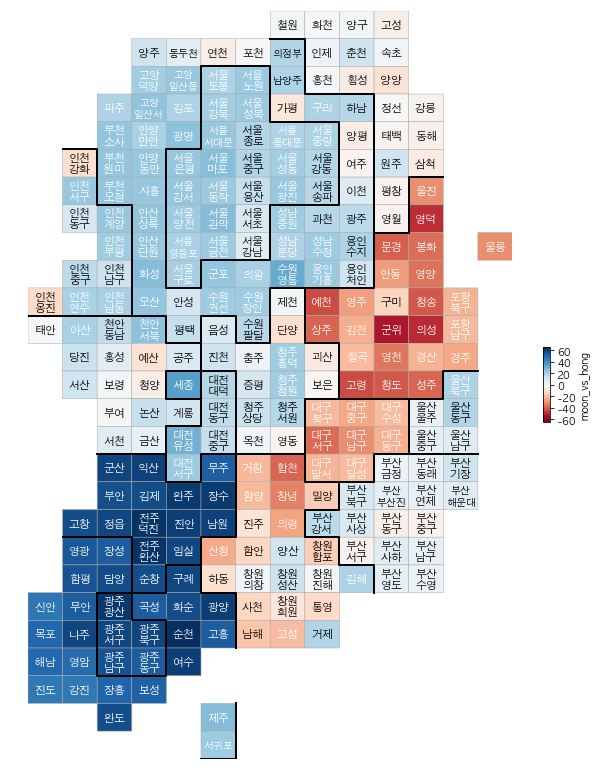

In [34]:
drawKorea('moon_vs_hong', final_elect_data, 'RdBu')

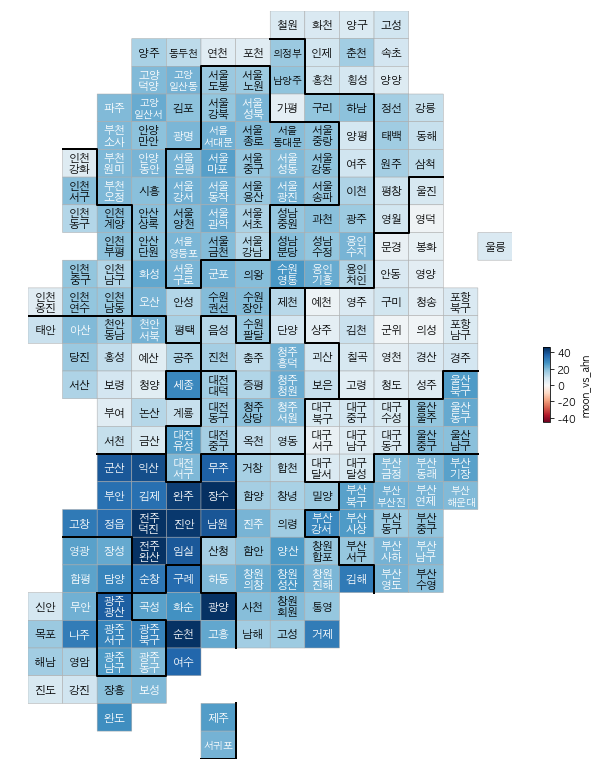

In [35]:
drawKorea('moon_vs_ahn', final_elect_data, 'RdBu')

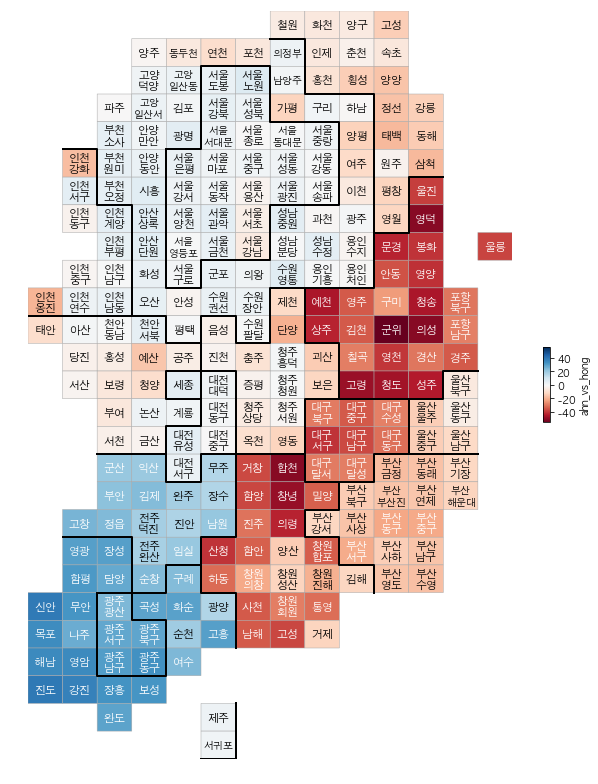

In [36]:
drawKorea('ahn_vs_hong', final_elect_data, 'RdBu')

In [37]:
import folium
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [38]:
pop_folium = final_elect_data.set_index('ID')

del pop_folium['광역시도']
del pop_folium['시군']

pop_folium.head()

,pop,moon,hong,ahn,rate_moon,rate_hong,rate_ahn,y,x,moon_vs_hong,moon_vs_ahn,ahn_vs_hong
ID,,,,,,,,,,,,
서울 종로,102566.0,42512.0,22325,22313,41.448433,21.766472,21.754773,4,6,19.681961,19.693661,-0.011700
서울 중구,82852.0,34062.0,17901,19372,41.111862,21.605996,23.381451,5,6,19.505866,17.730411,1.775455
서울 용산,148157.0,58081.0,35230,32109,39.202333,23.778829,21.672280,6,6,15.423503,17.530053,-2.106549
서울 성동,203175.0,86686.0,40566,45674,42.665682,19.966039,22.480128,5,7,22.699643,20.185554,2.514089
서울 광진,240030.0,105512.0,46368,52824,43.957839,19.317585,22.007249,6,7,24.640253,21.950590,2.689664


In [1]:
geo_path = '../data/05. skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

map = folium.Map(location=[36.2002, 127.054], zoom_start=6)
map.choropleth(geo_data = geo_str,
               data = pop_folium['moon_vs_hong'],
               columns = [pop_folium.index, pop_folium['moon_vs_hong']],
               fill_color = 'PuBu', #PuRd, YlGnBu
               key_on = 'feature.id')

map

NameError: name 'json' is not defined